[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kmani\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


                                           statement        label
0  Says the Annies List political group supports ...        false
1  When did the decline of coal start? It started...    half-true
2  Hillary Clinton agrees with John McCain "by vo...  mostly-true
3  Health care reform legislation is likely to ma...        false
4  The economic turnaround started at the end of ...    half-true
0    says annies list political group supports thir...
1    decline coal start started natural gas took st...
2    hillary clinton agrees john mccain voting give...
3    health care reform legislation likely mandate ...
4                 economic turnaround started end term
Name: clean_statement, dtype: object
(10240, 5000)
(10240,)
(8192, 5000) (2048, 5000)
Accuracy: 0.60107421875
              precision    recall  f1-score   support

           0       0.55      0.43      0.48       888
           1       0.63      0.73      0.68      1160

    accuracy                           0.60      2048
 

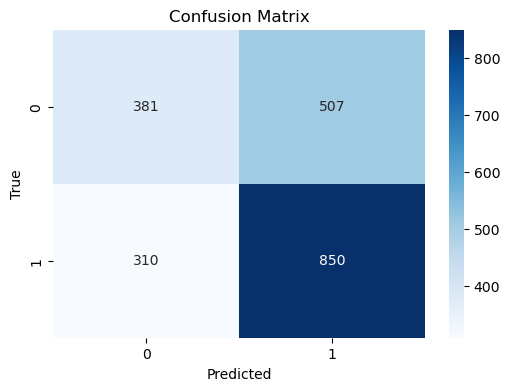

In [1]:
import pandas as pd
import zipfile
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Unzip the file
with zipfile.ZipFile('liar_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('liar_dataset')

# Load the training data
train_df = pd.read_csv('liar_dataset/train.tsv', sep='\t', header=None)

# Assign meaningful column names based on LIAR dataset documentation
train_df.columns = ['id', 'label', 'statement', 'subject', 'speaker', 'speaker_job_title', 
                    'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 
                    'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context']

# Show a few samples
print(train_df[['statement', 'label']].head())


#Data Preprocessing 

stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply cleaning
train_df['clean_statement'] = train_df['statement'].apply(clean_text)

# Preview
print(train_df['clean_statement'].head())


#feature extraction

# Define TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the cleaned statements
X = vectorizer.fit_transform(train_df['clean_statement'])

# Labels: map LIAR's multi-class into binary (optional)
# Original labels: pants-fire, false, barely-true, half-true, mostly-true, true
# We'll consider pants-fire/false/barely-true = FAKE, half-true/mostly-true/true = REAL

label_map = {
    'pants-fire': 0,
    'false': 0,
    'barely-true': 0,
    'half-true': 1,
    'mostly-true': 1,
    'true': 1
}

y = train_df['label'].map(label_map)

# Final feature and label sets
print(X.shape)
print(y.shape)


#train-test the ML model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)

#train the Ml model

# Initialize and train
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)


#evaluate the model

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kmani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                           statement        label
0  Says the Annies List political group supports ...        false
1  When did the decline of coal start? It started...    half-true
2  Hillary Clinton agrees with John McCain "by vo...  mostly-true
3  Health care reform legislation is likely to ma...        false
4  The economic turnaround started at the end of ...    half-true
Accuracy: 0.6337890625
              precision    recall  f1-score   support

           0       0.59      0.52      0.55       888
           1       0.66      0.72      0.69      1160

    accuracy                           0.63      2048
   macro avg       0.63      0.62      0.62      2048
weighted avg       0.63      0.63      0.63      2048



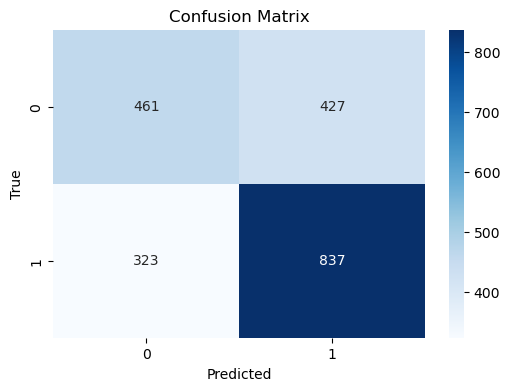

In [2]:
import pandas as pd
import zipfile
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
import seaborn as sns
import matplotlib.pyplot as plt

# Unzip the file
with zipfile.ZipFile('liar_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('liar_dataset')

# Load the training data
train_df = pd.read_csv('liar_dataset/train.tsv', sep='\t', header=None)

# Assign meaningful column names
train_df.columns = ['id', 'label', 'statement', 'subject', 'speaker', 'speaker_job_title', 
                    'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 
                    'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context']

# Show sample
print(train_df[['statement', 'label']].head())

# Data Preprocessing
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Clean main text
train_df['clean_statement'] = train_df['statement'].apply(clean_text)

# Also clean important metadata columns
train_df['subject_clean'] = train_df['subject'].apply(clean_text)
train_df['speaker_job_title_clean'] = train_df['speaker_job_title'].apply(clean_text)
train_df['party_affiliation_clean'] = train_df['party_affiliation'].apply(clean_text)

# Feature extraction
# TF-IDF for statement (main text)
vectorizer_statement = TfidfVectorizer(max_features=5000)
X_statement = vectorizer_statement.fit_transform(train_df['clean_statement'])

# TF-IDF for metadata: subject
vectorizer_subject = TfidfVectorizer(max_features=100)
X_subject = vectorizer_subject.fit_transform(train_df['subject_clean'])

# TF-IDF for metadata: speaker job title
vectorizer_job = TfidfVectorizer(max_features=100)
X_job = vectorizer_job.fit_transform(train_df['speaker_job_title_clean'])

# Label Encoding for metadata: party affiliation
label_encoder_party = LabelEncoder()
party_encoded = label_encoder_party.fit_transform(train_df['party_affiliation'].fillna('Unknown'))
party_encoded = party_encoded.reshape(-1, 1)  # reshape for hstack

# Combine all features together
X = hstack((X_statement, X_subject, X_job, party_encoded))

# Labels mapping
label_map = {
    'pants-fire': 0,
    'false': 0,
    'barely-true': 0,
    'half-true': 1,
    'mostly-true': 1,
    'true': 1
}
y = train_df['label'].map(label_map)

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kmani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[LightGBM] [Info] Number of positive: 4592, number of negative: 3600
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18843
[LightGBM] [Info] Number of data points in the train set: 8192, number of used features: 904
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.560547 -> initscore=0.243382
[LightGBM] [Info] Start training from score 0.243382
Model: Logistic Regression
Accuracy: 0.6338
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.52      0.55       888
           1       0.66      0.72      0.69      1160

    accuracy                           0.63      2048
   macro avg       0.63      0.62      0.62      2048
weighted avg       0.63      0.63      0.63      2048

Model: Random Forest
Accuracy: 0.6289
Classificatio

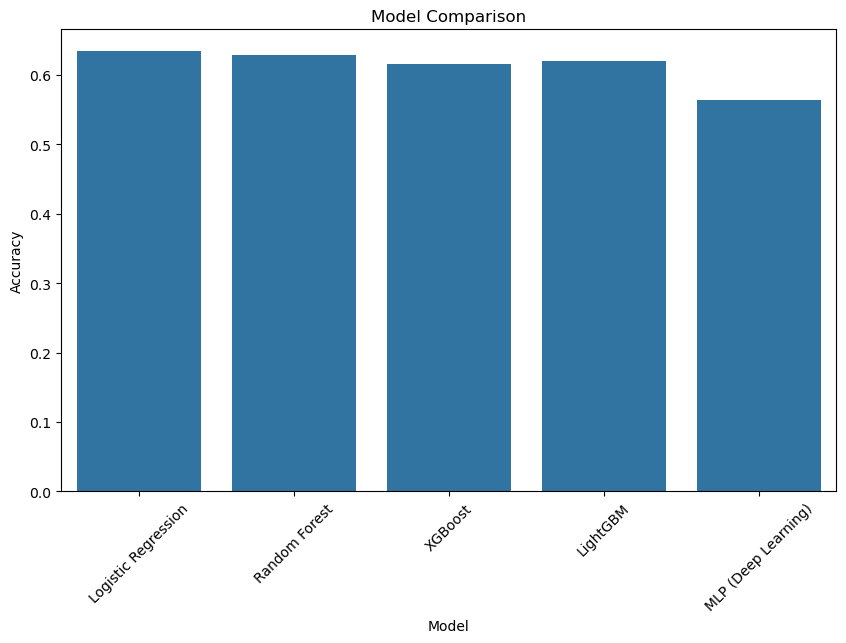

In [1]:
import pandas as pd
import zipfile
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Unzip the file
with zipfile.ZipFile('liar_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('liar_dataset')

# Load the training data
train_df = pd.read_csv('liar_dataset/train.tsv', sep='\t', header=None)

# Assign meaningful column names
train_df.columns = ['id', 'label', 'statement', 'subject', 'speaker', 'speaker_job_title', 
                    'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 
                    'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context']

# Data Preprocessing
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Clean main text
train_df['clean_statement'] = train_df['statement'].apply(clean_text)

# Also clean important metadata columns
train_df['subject_clean'] = train_df['subject'].apply(clean_text)
train_df['speaker_job_title_clean'] = train_df['speaker_job_title'].apply(clean_text)
train_df['party_affiliation_clean'] = train_df['party_affiliation'].apply(clean_text)

# Feature extraction
# TF-IDF for statement (main text)
vectorizer_statement = TfidfVectorizer(max_features=5000)
X_statement = vectorizer_statement.fit_transform(train_df['clean_statement'])

# TF-IDF for metadata: subject
vectorizer_subject = TfidfVectorizer(max_features=100)
X_subject = vectorizer_subject.fit_transform(train_df['subject_clean'])

# TF-IDF for metadata: speaker job title
vectorizer_job = TfidfVectorizer(max_features=100)
X_job = vectorizer_job.fit_transform(train_df['speaker_job_title_clean'])

# Label Encoding for metadata: party affiliation
label_encoder_party = LabelEncoder()
party_encoded = label_encoder_party.fit_transform(train_df['party_affiliation'].fillna('Unknown'))
party_encoded = party_encoded.reshape(-1, 1)  # reshape for hstack

# Combine all features together
X = hstack((X_statement, X_subject, X_job, party_encoded))

# Labels mapping
label_map = {
    'pants-fire': 0,
    'false': 0,
    'barely-true': 0,
    'half-true': 1,
    'mostly-true': 1,
    'true': 1
}
y = train_df['label'].map(label_map)

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models for comparison
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(n_estimators=100, random_state=42),
    "LightGBM": lgb.LGBMClassifier(n_estimators=100, random_state=42),
    "MLP (Deep Learning)": MLPClassifier(hidden_layer_sizes=(50,50), max_iter=1000, random_state=42)
}

# Function to evaluate models
def evaluate_model(model_name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    return accuracy, report

# Results dictionary
results = {}

# Train and evaluate each model
for model_name, model in models.items():
    accuracy, report = evaluate_model(model_name, model, X_train, X_test, y_train, y_test)
    results[model_name] = {
        'accuracy': accuracy,
        'report': report
    }

# Display results
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print("Classification Report:")
    print(result['report'])
    print("="*50)

# Optionally: Plot accuracy comparison
model_names = list(results.keys())
accuracies = [result['accuracy'] for result in results.values()]

plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracies)
plt.title("Model Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()


In [4]:
pip install lightgbm


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   --------------------- ------------------ 0.8/1.5 MB 5.6 MB/s eta 0:00:01
   ------------------------------------ --- 1.3/1.5 MB 3.2 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 3.0 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kmani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Performing Grid Search for XGBoost...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Performing Grid Search for Random Forest...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters for Random Forest: {'max_depth': None, 'n_estimators': 200}
Performing Grid Search for LightGBM...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[LightGBM] [Info] Number of positive: 4592, number of negative: 3600
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.319122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18843
[LightGBM] [Info] Number of data points in the train set: 8192, number of used features: 904
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.560547 -> initscore=0.243382
[LightGBM] [Info] Start traini

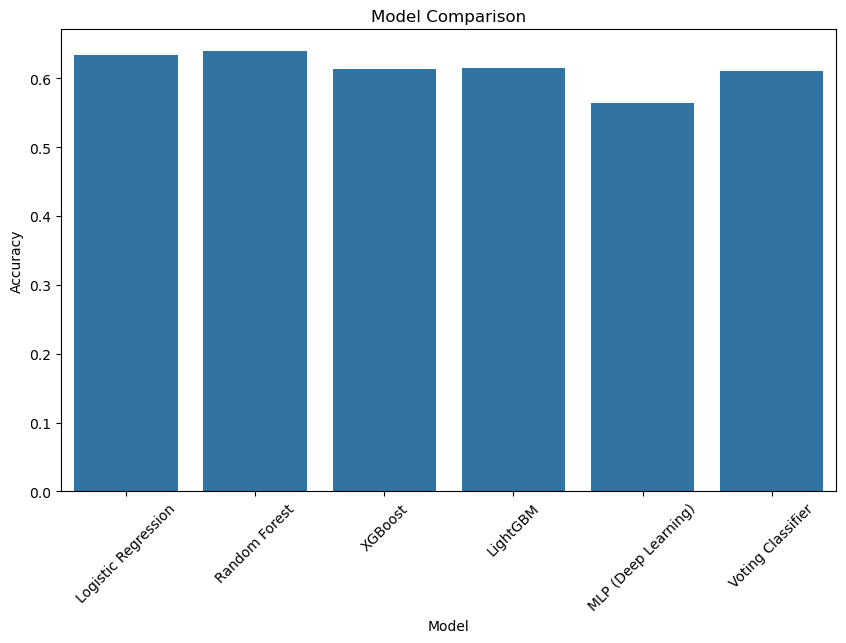

In [2]:
import pandas as pd
import zipfile
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Unzip the file
with zipfile.ZipFile('liar_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('liar_dataset')

# Load the training data
train_df = pd.read_csv('liar_dataset/train.tsv', sep='\t', header=None)

# Assign meaningful column names
train_df.columns = ['id', 'label', 'statement', 'subject', 'speaker', 'speaker_job_title', 
                    'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 
                    'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context']

# Data Preprocessing
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Clean main text
train_df['clean_statement'] = train_df['statement'].apply(clean_text)

# Also clean important metadata columns
train_df['subject_clean'] = train_df['subject'].apply(clean_text)
train_df['speaker_job_title_clean'] = train_df['speaker_job_title'].apply(clean_text)
train_df['party_affiliation_clean'] = train_df['party_affiliation'].apply(clean_text)

# Feature extraction
# TF-IDF for statement (main text)
vectorizer_statement = TfidfVectorizer(max_features=5000)
X_statement = vectorizer_statement.fit_transform(train_df['clean_statement'])

# TF-IDF for metadata: subject
vectorizer_subject = TfidfVectorizer(max_features=100)
X_subject = vectorizer_subject.fit_transform(train_df['subject_clean'])

# TF-IDF for metadata: speaker job title
vectorizer_job = TfidfVectorizer(max_features=100)
X_job = vectorizer_job.fit_transform(train_df['speaker_job_title_clean'])

# Label Encoding for metadata: party affiliation
label_encoder_party = LabelEncoder()
party_encoded = label_encoder_party.fit_transform(train_df['party_affiliation'].fillna('Unknown'))
party_encoded = party_encoded.reshape(-1, 1)  # reshape for hstack

# Combine all features together
X = hstack((X_statement, X_subject, X_job, party_encoded))

# Labels mapping
label_map = {
    'pants-fire': 0,
    'false': 0,
    'barely-true': 0,
    'half-true': 1,
    'mostly-true': 1,
    'true': 1
}
y = train_df['label'].map(label_map)

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning for XGBoost, Random Forest, and LightGBM
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None]
}
param_grid_lgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7]
}

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42),
    "MLP (Deep Learning)": MLPClassifier(hidden_layer_sizes=(50,50), max_iter=1000, random_state=42)
}

# Tune models with GridSearchCV
grid_searches = {
    "XGBoost": GridSearchCV(models["XGBoost"], param_grid_xgb, cv=3, n_jobs=-1, verbose=1),
    "Random Forest": GridSearchCV(models["Random Forest"], param_grid_rf, cv=3, n_jobs=-1, verbose=1),
    "LightGBM": GridSearchCV(models["LightGBM"], param_grid_lgb, cv=3, n_jobs=-1, verbose=1)
}

# Fit grid search for each model
for model_name, grid_search in grid_searches.items():
    print(f"Performing Grid Search for {model_name}...")
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    models[model_name] = grid_search.best_estimator_

# Create a Voting Classifier ensemble of the best models
voting_clf = VotingClassifier(estimators=[
    ('logreg', models['Logistic Regression']),
    ('rf', models['Random Forest']),
    ('xgb', models['XGBoost']),
    ('lgb', models['LightGBM']),
    ('mlp', models['MLP (Deep Learning)'])
], voting='soft')

# Function to evaluate models
def evaluate_model(model_name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    return accuracy, report

# Results dictionary
results = {}

# Train and evaluate each model
for model_name, model in models.items():
    accuracy, report = evaluate_model(model_name, model, X_train, X_test, y_train, y_test)
    results[model_name] = {
        'accuracy': accuracy,
        'report': report
    }

# Evaluate the ensemble model
accuracy, report = evaluate_model("Voting Classifier", voting_clf, X_train, X_test, y_train, y_test)
results["Voting Classifier"] = {
    'accuracy': accuracy,
    'report': report
}

# Display results
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print("Classification Report:")
    print(result['report'])
    print("="*50)

# Optionally: Plot accuracy comparison
model_names = list(results.keys())
accuracies = [result['accuracy'] for result in results.values()]

plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracies)
plt.title("Model Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kmani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Performing Grid Search for Random Forest...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters for Random Forest: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Model: Random Forest
Accuracy: 0.6162
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.28      0.38       888
           1       0.61      0.88      0.72      1160

    accuracy                           0.62      2048
   macro avg       0.62      0.58      0.55      2048
weighted avg       0.62      0.62      0.58      2048



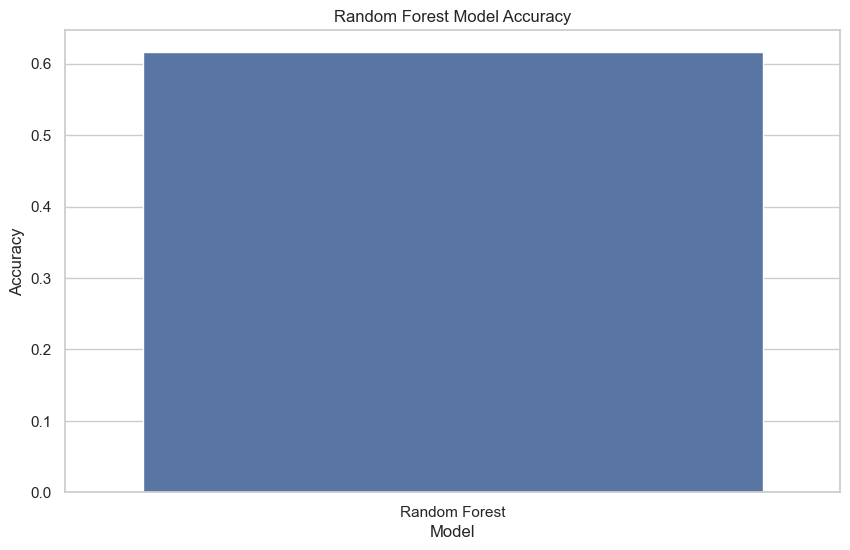

In [1]:
import pandas as pd
import zipfile
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
import seaborn as sns
import matplotlib.pyplot as plt

# Download the necessary resources for nltk
nltk.download('stopwords')

# Unzip the file
with zipfile.ZipFile('liar_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('liar_dataset')

# Load the training data
train_df = pd.read_csv('liar_dataset/train.tsv', sep='\t', header=None)

# Assign meaningful column names
train_df.columns = ['id', 'label', 'statement', 'subject', 'speaker', 'speaker_job_title', 
                    'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 
                    'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context']

# Data Preprocessing
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Clean main text
train_df['clean_statement'] = train_df['statement'].apply(clean_text)

# Also clean important metadata columns
train_df['subject_clean'] = train_df['subject'].apply(clean_text)
train_df['speaker_job_title_clean'] = train_df['speaker_job_title'].apply(clean_text)
train_df['party_affiliation_clean'] = train_df['party_affiliation'].apply(clean_text)

# Feature extraction
# TF-IDF for statement (main text) with reduced number of features
vectorizer_statement = TfidfVectorizer(max_features=1000)  # Reduced to 1000 features
X_statement = vectorizer_statement.fit_transform(train_df['clean_statement'])

# TF-IDF for metadata: subject with reduced features
vectorizer_subject = TfidfVectorizer(max_features=50)  # Reduced to 50 features
X_subject = vectorizer_subject.fit_transform(train_df['subject_clean'])

# TF-IDF for metadata: speaker job title with reduced features
vectorizer_job = TfidfVectorizer(max_features=50)  # Reduced to 50 features
X_job = vectorizer_job.fit_transform(train_df['speaker_job_title_clean'])

# Label Encoding for metadata: party affiliation
label_encoder_party = LabelEncoder()
party_encoded = label_encoder_party.fit_transform(train_df['party_affiliation'].fillna('Unknown'))
party_encoded = party_encoded.reshape(-1, 1)  # reshape for hstack

# Combine all features together
X = hstack((X_statement, X_subject, X_job, party_encoded))

# Labels mapping
label_map = {
    'pants-fire': 0,
    'false': 0,
    'barely-true': 0,
    'half-true': 1,
    'mostly-true': 1,
    'true': 1
}
y = train_df['label'].map(label_map)

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Subsample the training data for faster grid search
X_train_subsample, _, y_train_subsample, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=42)

# Reduced GridSearchCV parameter space for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],  # Smaller range for number of trees
    'max_depth': [10, 20],  # Limited depth
    'min_samples_split': [2, 5],  # Limited minimum samples
    'min_samples_leaf': [1, 2],  # Limited leaf samples
    'max_features': ['sqrt']  # Limited to sqrt, which is common for Random Forest
}

# Define Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=3, n_jobs=-1, verbose=1)

# Fit grid search for Random Forest
print("Performing Grid Search for Random Forest...")
grid_search_rf.fit(X_train_subsample, y_train_subsample)
print(f"Best parameters for Random Forest: {grid_search_rf.best_params_}")
rf_model = grid_search_rf.best_estimator_

# Train the Random Forest model with the best parameters
rf_model.fit(X_train, y_train)

# Evaluate the Random Forest model
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

# Results dictionary
results = {
    'Random Forest': {
        'accuracy': accuracy_rf,
        'report': report_rf
    }
}

# Display the results for Random Forest
print(f"Model: Random Forest")
print(f"Accuracy: {accuracy_rf:.4f}")
print("Classification Report:")
print(report_rf)

# Optionally: Plot accuracy comparison for Random Forest
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=['Random Forest'], y=[accuracy_rf])
plt.title("Random Forest Model Accuracy")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kmani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Performing Randomized Search for Random Forest...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 200, 'max_depth': 10}
Model: Random Forest
Accuracy: 0.6157
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.27      0.38       888
           1       0.61      0.88      0.72      1160

    accuracy                           0.62      2048
   macro avg       0.62      0.58      0.55      2048
weighted avg       0.62      0.62      0.57      2048



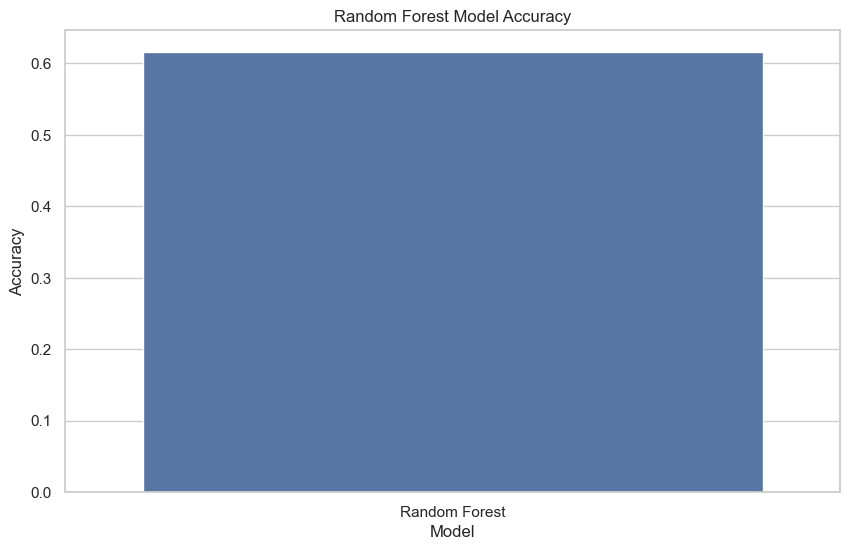

In [2]:
import pandas as pd
import zipfile
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Download the necessary resources for nltk
nltk.download('stopwords')

# Unzip the file
with zipfile.ZipFile('liar_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('liar_dataset')

# Load the training data
train_df = pd.read_csv('liar_dataset/train.tsv', sep='\t', header=None)

# Assign meaningful column names
train_df.columns = ['id', 'label', 'statement', 'subject', 'speaker', 'speaker_job_title', 
                    'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 
                    'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context']

# Data Preprocessing
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Clean main text
train_df['clean_statement'] = train_df['statement'].apply(clean_text)

# Also clean important metadata columns
train_df['subject_clean'] = train_df['subject'].apply(clean_text)
train_df['speaker_job_title_clean'] = train_df['speaker_job_title'].apply(clean_text)
train_df['party_affiliation_clean'] = train_df['party_affiliation'].apply(clean_text)

# Feature extraction
# TF-IDF for statement (main text) with reduced number of features
vectorizer_statement = TfidfVectorizer(max_features=1000)  # Reduced to 1000 features
X_statement = vectorizer_statement.fit_transform(train_df['clean_statement'])

# TF-IDF for metadata: subject with reduced features
vectorizer_subject = TfidfVectorizer(max_features=50)  # Reduced to 50 features
X_subject = vectorizer_subject.fit_transform(train_df['subject_clean'])

# TF-IDF for metadata: speaker job title with reduced features
vectorizer_job = TfidfVectorizer(max_features=50)  # Reduced to 50 features
X_job = vectorizer_job.fit_transform(train_df['speaker_job_title_clean'])

# Label Encoding for metadata: party affiliation
label_encoder_party = LabelEncoder()
party_encoded = label_encoder_party.fit_transform(train_df['party_affiliation'].fillna('Unknown'))
party_encoded = party_encoded.reshape(-1, 1)  # reshape for hstack

# Combine all features together
X = hstack((X_statement, X_subject, X_job, party_encoded))

# Labels mapping
label_map = {
    'pants-fire': 0,
    'false': 0,
    'barely-true': 0,
    'half-true': 1,
    'mostly-true': 1,
    'true': 1
}
y = train_df['label'].map(label_map)

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reduce the size of the training set for faster tuning
X_train_subsample, _, y_train_subsample, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=42)

# Reduced RandomizedSearchCV parameter space for Random Forest
param_dist_rf = {
    'n_estimators': [100, 150, 200],  # Smaller range for number of trees
    'max_depth': [10, 20, 30],  # Limited depth
    'min_samples_split': [2, 5],  # Limited minimum samples
    'min_samples_leaf': [1, 2],  # Limited leaf samples
    'max_features': [100, 200],  # Limit max features to smaller set
}

# Define Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# RandomizedSearchCV for Random Forest
random_search_rf = RandomizedSearchCV(rf_model, param_dist_rf, n_iter=5, cv=3, n_jobs=-1, verbose=1, random_state=42)

# Fit random search for Random Forest
print("Performing Randomized Search for Random Forest...")
random_search_rf.fit(X_train_subsample, y_train_subsample)
print(f"Best parameters for Random Forest: {random_search_rf.best_params_}")
rf_model = random_search_rf.best_estimator_

# Train the Random Forest model with the best parameters
rf_model.fit(X_train, y_train)

# Evaluate the Random Forest model
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

# Results dictionary
results = {
    'Random Forest': {
        'accuracy': accuracy_rf,
        'report': report_rf
    }
}

# Display the results for Random Forest
print(f"Model: Random Forest")
print(f"Accuracy: {accuracy_rf:.4f}")
print("Classification Report:")
print(report_rf)

# Optionally: Plot accuracy comparison for Random Forest
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=['Random Forest'], y=[accuracy_rf])
plt.title("Random Forest Model Accuracy")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.show()


In [3]:
pip install tensorflow scikit-learn pandas numpy



   ---------------------------------------- 0.0/376.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/376.0 MB 10.1 MB/s eta 0:00:38
   ---------------------------------------- 3.9/376.0 MB 12.4 MB/s eta 0:00:31
    --------------------------------------- 7.9/376.0 MB 13.9 MB/s eta 0:00:27
   - -------------------------------------- 11.0/376.0 MB 14.0 MB/s eta 0:00:27
   - -------------------------------------- 14.9/376.0 MB 15.1 MB/s eta 0:00:24
   -- ------------------------------------- 19.1/376.0 MB 15.9 MB/s eta 0:00:23
   -- ------------------------------------- 22.8/376.0 MB 16.4 MB/s eta 0:00:22
   -- ------------------------------------- 27.8/376.0 MB 17.1 MB/s eta 0:00:21
   --- ------------------------------------ 31.5/376.0 MB 16.9 MB/s eta 0:00:21
   --- ------------------------------------ 35.1/376.0 MB 17.0 MB/s eta 0:00:21
   ---- ----------------------------------- 39.1/376.0 MB 17.1 MB/s eta 0:00:20
   ---- ----------------------------------- 42.5/37

In [4]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, classification_report

# Download necessary resources for nltk
nltk.download('stopwords')

# Load and preprocess the data
train_df = pd.read_csv('liar_dataset/train.tsv', sep='\t', header=None)

# Assign meaningful column names
train_df.columns = ['id', 'label', 'statement', 'subject', 'speaker', 'speaker_job_title', 
                    'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 
                    'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context']

# Clean the text data
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

train_df['clean_statement'] = train_df['statement'].apply(clean_text)

# Prepare labels
label_map = {
    'pants-fire': 0,
    'false': 0,
    'barely-true': 0,
    'half-true': 1,
    'mostly-true': 1,
    'true': 1
}
y = train_df['label'].map(label_map)

# Tokenize the text data
tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(train_df['clean_statement'])
X = tokenizer.texts_to_sequences(train_df['clean_statement'])

# Pad sequences to ensure equal input size for LSTM
max_sequence_length = 200  # You can adjust this value based on your data
X = pad_sequences(X, maxlen=max_sequence_length)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM model
model = Sequential()

# Add an embedding layer to convert word indices to word embeddings
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_sequence_length))

# Add an LSTM layer
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))

# Add a Dense layer with a sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test), verbose=2)

# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype('int32')  # Convert probabilities to 0 or 1

# Print the results
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"LSTM Model Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kmani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\kmani\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
128/128 - 165s - 1s/step - accuracy: 0.5778 - loss: 0.6748 - val_accuracy: 0.5830 - val_loss: 0.6667
Epoch 2/5
128/128 - 166s - 1s/step - accuracy: 0.6924 - loss: 0.5888 - val_accuracy: 0.5981 - val_loss: 0.6860
Epoch 3/5
128/128 - 185s - 1s/step - accuracy: 0.7662 - loss: 0.4915 - val_accuracy: 0.5811 - val_loss: 0.7700
Epoch 4/5
128/128 - 140s - 1s/step - accuracy: 0.8176 - loss: 0.4034 - val_accuracy: 0.5728 - val_loss: 0.9005
Epoch 5/5
128/128 - 157s - 1s/step - accuracy: 0.8582 - loss: 0.3237 - val_accuracy: 0.5684 - val_loss: 1.0509
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step
LSTM Model Accuracy: 0.5684
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.47      0.48       888
           1       0.61      0.65      0.63      1160

    accuracy                           0.57      2048
   macro avg       0.56      0.56      0.56      2048
weighted avg       0.56      0.57      0.57      2048



In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load the dataset (replace with your dataset loading method)
train_df = pd.read_csv('liar_dataset/train.tsv', sep='\t', header=None)
train_df.columns = ['id', 'label', 'statement', 'subject', 'speaker', 'speaker_job_title', 
                    'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 
                    'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context']

# Clean the text data
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

train_df['clean_statement'] = train_df['statement'].apply(clean_text)

# Prepare labels
label_map = {
    'pants-fire': 0,
    'false': 0,
    'barely-true': 0,
    'half-true': 1,
    'mostly-true': 1,
    'true': 1
}
y = train_df['label'].map(label_map)

# TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(train_df['clean_statement'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_model = XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_model.predict(X_test)

# Print results
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"XGBoost Model Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)


XGBoost Model Accuracy: 0.5840
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.47      0.50       888
           1       0.62      0.67      0.65      1160

    accuracy                           0.58      2048
   macro avg       0.57      0.57      0.57      2048
weighted avg       0.58      0.58      0.58      2048



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kmani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Random Forest Model Accuracy: 0.5908
Classification Report for RandomForest:
              precision    recall  f1-score   support

           0       0.70      0.10      0.17       888
           1       0.58      0.97      0.73      1160

    accuracy                           0.59      2048
   macro avg       0.64      0.53      0.45      2048
weighted avg       0.63      0.59      0.49      2048



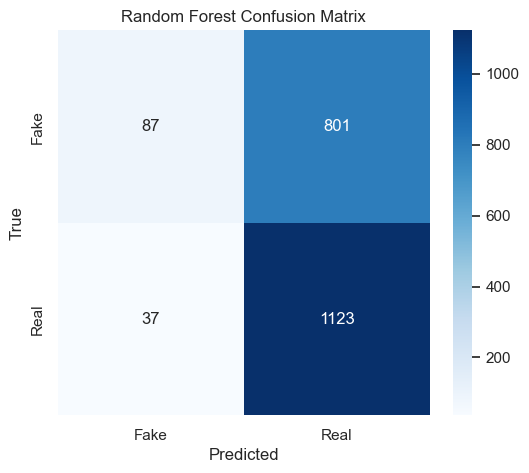

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
XGBoost Model Accuracy: 0.5908
Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.57      0.24      0.33       888
           1       0.60      0.86      0.70      1160

    accuracy                           0.59      2048
   macro avg       0.58      0.55      0.52      2048
weighted avg       0.58      0.59      0.54      2048



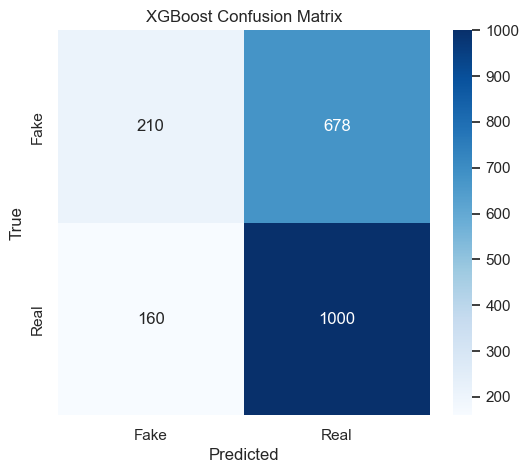

In [6]:
import pandas as pd
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# Download necessary NLTK resources
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Load the dataset
train_df = pd.read_csv('liar_dataset/train.tsv', sep='\t', header=None)

# Assign meaningful column names
train_df.columns = ['id', 'label', 'statement', 'subject', 'speaker', 'speaker_job_title', 
                    'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 
                    'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context']

# Data Preprocessing
def clean_text(text):
    text = str(text).lower()  # Convert text to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetical characters
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

# Clean text column
train_df['clean_statement'] = train_df['statement'].apply(clean_text)

# Feature extraction (TF-IDF)
vectorizer_statement = TfidfVectorizer(max_features=5000)
X_statement = vectorizer_statement.fit_transform(train_df['clean_statement'])

# Label encoding (mapping truthfulness labels to binary)
label_map = {
    'pants-fire': 0,
    'false': 0,
    'barely-true': 0,
    'half-true': 1,
    'mostly-true': 1,
    'true': 1
}
y = train_df['label'].map(label_map)

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_statement, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=20, min_samples_split=5, min_samples_leaf=2)
rf_model.fit(X_train, y_train)

# Evaluate the RandomForest model
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Print RandomForest results
print(f"Random Forest Model Accuracy: {accuracy_rf:.4f}")
print("Classification Report for RandomForest:")
print(report_rf)

# Plot confusion matrix for RandomForest
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap="Blues", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Hyperparameter tuning using GridSearchCV for XGBoost
xgb_model = XGBClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [6, 10, 20],
    'learning_rate': [0.01, 0.1],
}

grid_search_xgb = GridSearchCV(xgb_model, param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search_xgb.fit(X_train, y_train)

# Best parameters from grid search
print("Best Parameters for XGBoost:", grid_search_xgb.best_params_)

# Train the XGBoost model with the best parameters
xgb_best_model = grid_search_xgb.best_estimator_
xgb_best_model.fit(X_train, y_train)

# Predict and evaluate the XGBoost model
y_pred_xgb = xgb_best_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

# Print XGBoost results
print(f"XGBoost Model Accuracy: {accuracy_xgb:.4f}")
print("Classification Report for XGBoost:")
print(report_xgb)

# Plot confusion matrix for XGBoost
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap="Blues", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kmani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best LR params: {'C': 1, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}

Test Accuracy: 0.6338

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.48      0.53       553
           1       0.65      0.75      0.70       714

    accuracy                           0.63      1267
   macro avg       0.63      0.62      0.62      1267
weighted avg       0.63      0.63      0.63      1267



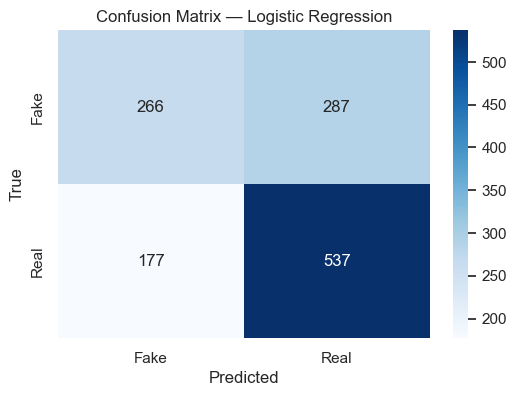

In [9]:
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.sparse import hstack
import seaborn as sns
import matplotlib.pyplot as plt

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return ' '.join(w for w in text.split() if w not in stop_words)

# 1) Load all splits
cols = ['id','label','statement','subject','speaker','speaker_job_title',
        'state_info','party_affiliation','barely_true','false','half_true',
        'mostly_true','pants_on_fire','context']
train = pd.read_csv('liar_dataset/train.tsv', sep='\t', header=None, names=cols)
valid = pd.read_csv('liar_dataset/valid.tsv', sep='\t', header=None, names=cols)
test  = pd.read_csv('liar_dataset/test.tsv',  sep='\t', header=None, names=cols)

# 2) Clean text + metadata
for df in (train, valid, test):
    df['clean_statement']      = df['statement'].apply(clean_text)
    df['subject_clean']        = df['subject']  .apply(clean_text)
    df['job_clean']            = df['speaker_job_title'].apply(clean_text)
    df['party_clean']          = df['party_affiliation'].fillna('Unknown').apply(clean_text)

# 3) Combine train+valid for CV & training
train_valid = pd.concat([train, valid], ignore_index=True)

# 4) TF-IDF on statements (unigrams + bigrams)
tfidf_stmt = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_stmt_tv  = tfidf_stmt.fit_transform(train_valid['clean_statement'])
X_stmt_test= tfidf_stmt.transform(test['clean_statement'])

# 5) TF-IDF on metadata: subject & job title (unigrams only)
tfidf_sub = TfidfVectorizer(max_features=200)
tfidf_job = TfidfVectorizer(max_features=200)
X_sub_tv   = tfidf_sub.fit_transform(train_valid['subject_clean'])
X_sub_test = tfidf_sub.transform(test['subject_clean'])
X_job_tv   = tfidf_job.fit_transform(train_valid['job_clean'])
X_job_test = tfidf_job.transform(test['job_clean'])

# 6) Encode party affiliation
le_party     = LabelEncoder()
party_enc    = le_party.fit_transform(train_valid['party_clean'])
party_enc_test = le_party.transform(test['party_clean'])
X_party      = party_enc.reshape(-1,1)
X_party_test = party_enc_test.reshape(-1,1)

# 7) Stack all features
X_trainval = hstack([X_stmt_tv, X_sub_tv, X_job_tv, X_party])
X_test     = hstack([X_stmt_test, X_sub_test, X_job_test, X_party_test])

# 8) Prepare labels
label_map = {'pants-fire':0,'false':0,'barely-true':0,'half-true':1,'mostly-true':1,'true':1}
y_trainval = train_valid['label'].map(label_map)
y_test     = test['label'].map(label_map)

# 9) Hyperparameter tuning for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'class_weight': [None, 'balanced'],
    'solver': ['liblinear']
}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, n_jobs=-1, verbose=1)
grid.fit(X_trainval, y_trainval)
best = grid.best_estimator_
print("Best LR params:", grid.best_params_)

# 10) Evaluate on test set
y_pred = best.predict(X_test)
acc  = accuracy_score(y_test, y_pred)
rep  = classification_report(y_test, y_pred)
cm   = confusion_matrix(y_test, y_pred)

print(f"\nTest Accuracy: {acc:.4f}\n")
print("Classification Report:\n", rep)

# 11) Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake','Real'], yticklabels=['Fake','Real'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — Logistic Regression")
plt.show()


In [15]:
!pip install transformers




   ---------------------------------------- 0.0/10.4 MB ? eta -:--:--
   --- ------------------------------------ 0.8/10.4 MB 4.8 MB/s eta 0:00:03
   ------- -------------------------------- 1.8/10.4 MB 5.3 MB/s eta 0:00:02
   ------------ --------------------------- 3.1/10.4 MB 5.8 MB/s eta 0:00:02
   ----------------- ---------------------- 4.5/10.4 MB 6.0 MB/s eta 0:00:01
   ------------------------ --------------- 6.3/10.4 MB 6.3 MB/s eta 0:00:01
   ----------------------------- ---------- 7.6/10.4 MB 6.3 MB/s eta 0:00:01
   ---------------------------------- ----- 8.9/10.4 MB 6.4 MB/s eta 0:00:01
   ---------------------------------------  10.2/10.4 MB 6.4 MB/s eta 0:00:01
   ---------------------------------------- 10.4/10.4 MB 6.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ------------------------------ --------- 1.8/2.4 MB 8.4 MB/s eta 0:00:01
   ---------------------------------------- 2.4/2.4 MB 6.9 MB/s eta 0:00:00


In [16]:
!pip install torch
!pip install datasets

   ---------------------------------------- 0.0/212.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/212.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/212.5 MB ? eta -:--:--
   ---------------------------------------- 1.0/212.5 MB 2.8 MB/s eta 0:01:16
   ---------------------------------------- 1.3/212.5 MB 2.2 MB/s eta 0:01:35
   ---------------------------------------- 2.1/212.5 MB 2.6 MB/s eta 0:01:23
   ---------------------------------------- 2.6/212.5 MB 2.6 MB/s eta 0:01:21
    --------------------------------------- 3.9/212.5 MB 3.2 MB/s eta 0:01:05
   - -------------------------------------- 5.8/212.5 MB 3.9 MB/s eta 0:00:53
   - -------------------------------------- 7.3/212.5 MB 4.3 MB/s eta 0:00:48
   - -------------------------------------- 9.7/212.5 MB 5.1 MB/s eta 0:00:40
   -- ------------------------------------- 12.3/212.5 MB 5.8 MB/s eta 0:00:35
   -- ------------------------------------- 14.2/212.5 MB 6.1 MB/s eta 0:00:33
   --

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from datasets import load_dataset
import numpy as np

# Load LIAR dataset 
import pandas as pd
train_df = pd.read_csv('liar_dataset/train.tsv', sep='\t', header=None)
train_df.columns = ['id', 'label', 'statement', 'subject', 'speaker', 'speaker_job_title', 
                    'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 
                    'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context']

# Preprocess the data: 
# Mapping labels: 'pants-fire' -> 0, 'false' -> 0, 'barely-true' -> 0, 'half-true' -> 1, 'mostly-true' -> 1, 'true' -> 1
label_map = {
    'pants-fire': 0,
    'false': 0,
    'barely-true': 0,
    'half-true': 1,
    'mostly-true': 1,
    'true': 1
}

train_df['label'] = train_df['label'].map(label_map)

# Split the dataset into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_df['statement'], train_df['label'], test_size=0.2, random_state=42)

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization function to convert sentences to token ids
def tokenize_data(texts, tokenizer, max_length=128):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=max_length, return_tensors="pt")

# Tokenize the training and validation data
train_encodings = tokenize_data(X_train, tokenizer)
val_encodings = tokenize_data(X_val, tokenizer)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(y_train.values)
val_labels = torch.tensor(y_val.values)

# Create Dataset class to feed into DataLoader
class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Create DataLoader for training and validation
train_dataset = NewsDataset(train_encodings, train_labels)
val_dataset = NewsDataset(val_encodings, val_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Set up the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Define the training loop
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in data_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        optimizer.zero_grad()
        outputs = model(**batch)
        
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    return total_loss / len(data_loader)

# Define the evaluation loop
def eval_epoch(model, data_loader, device):
    model.eval()
    total_loss = 0
    predictions, true_labels = [], []
    
    with torch.no_grad():
        for batch in data_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            
            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits
            
            total_loss += loss.item()
            predictions.extend(torch.argmax(logits, dim=-1).cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())
    
    accuracy = accuracy_score(true_labels, predictions)
    return total_loss / len(data_loader), accuracy, predictions, true_labels

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training and evaluation
epochs = 3
best_val_accuracy = 0

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    # Train for one epoch
    train_loss = train_epoch(model, train_loader, optimizer, device)
    print(f"Training loss: {train_loss}")
    
    # Evaluate the model
    val_loss, val_accuracy, predictions, true_labels = eval_epoch(model, val_loader, device)
    print(f"Validation loss: {val_loss}")
    print(f"Validation accuracy: {val_accuracy}")
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), "best_model.pth")

# Load the best model for final evaluation
model.load_state_dict(torch.load("best_model.pth"))

# Final evaluation on validation set
val_loss, val_accuracy, predictions, true_labels = eval_epoch(model, val_loader, device)
print(f"Final Validation Accuracy: {val_accuracy}")
print(classification_report(true_labels, predictions))


ImportError: cannot import name 'AdamW' from 'transformers' (C:\Users\kmani\anaconda3\Lib\site-packages\transformers\__init__.py)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kmani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Best Logistic Regression Parameters: {'C': 1, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
Test Accuracy: 0.6270
              precision    recall  f1-score   support

           0       0.58      0.51      0.54       888
           1       0.66      0.72      0.69      1160

    accuracy                           0.63      2048
   macro avg       0.62      0.61      0.61      2048
weighted avg       0.62      0.63      0.62      2048



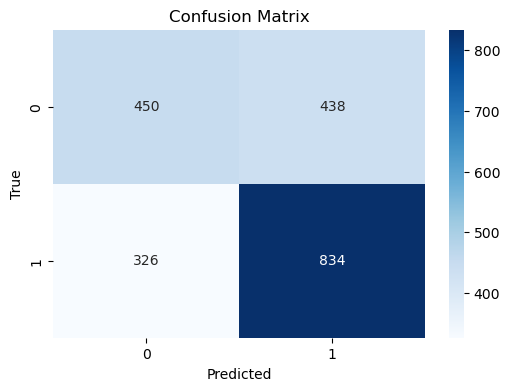

In [2]:
import pandas as pd
import zipfile
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
import seaborn as sns
import matplotlib.pyplot as plt

# Download stopwords from nltk
nltk.download('stopwords')

# Unzip the dataset
with zipfile.ZipFile('liar_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('liar_dataset')

# Load the training data
train_df = pd.read_csv('liar_dataset/train.tsv', sep='\t', header=None)

# Assign meaningful column names
train_df.columns = ['id', 'label', 'statement', 'subject', 'speaker', 'speaker_job_title', 
                    'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 
                    'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context']

# Data Preprocessing
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Clean the main text
train_df['clean_statement'] = train_df['statement'].apply(clean_text)

# Clean important metadata columns
train_df['subject_clean'] = train_df['subject'].apply(clean_text)
train_df['speaker_job_title_clean'] = train_df['speaker_job_title'].apply(clean_text)
train_df['party_affiliation_clean'] = train_df['party_affiliation'].apply(clean_text)

# Feature extraction: TF-IDF for statements (main text)
vectorizer_statement = TfidfVectorizer(max_features=10000)
X_statement = vectorizer_statement.fit_transform(train_df['clean_statement'])

# TF-IDF for metadata: subject
vectorizer_subject = TfidfVectorizer(max_features=200)
X_subject = vectorizer_subject.fit_transform(train_df['subject_clean'])

# TF-IDF for metadata: speaker job title
vectorizer_job = TfidfVectorizer(max_features=200)
X_job = vectorizer_job.fit_transform(train_df['speaker_job_title_clean'])

# Label Encoding for party affiliation
label_encoder_party = LabelEncoder()
party_encoded = label_encoder_party.fit_transform(train_df['party_affiliation'].fillna('Unknown'))
party_encoded = party_encoded.reshape(-1, 1)  # reshape for hstack

# Combine all features
X = hstack((X_statement, X_subject, X_job, party_encoded))

# Labels mapping
label_map = {
    'pants-fire': 0,
    'false': 0,
    'barely-true': 0,
    'half-true': 1,
    'mostly-true': 1,
    'true': 1
}
y = train_df['label'].map(label_map)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression model with Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear'],
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best hyperparameters
print(f"Best Logistic Regression Parameters: {grid_search.best_params_}")

# Train the model with the best parameters
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kmani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\kmani\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best Logistic Regression Parameters: {'C': 5, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}
Test Accuracy: 0.6221
              precision    recall  f1-score   support

           0       0.56      0.61      0.58       888
           1       0.68      0.63      0.65      1160

    accuracy                           0.62      2048
   macro avg       0.62      0.62      0.62      2048
weighted avg       0.63      0.62      0.62      2048



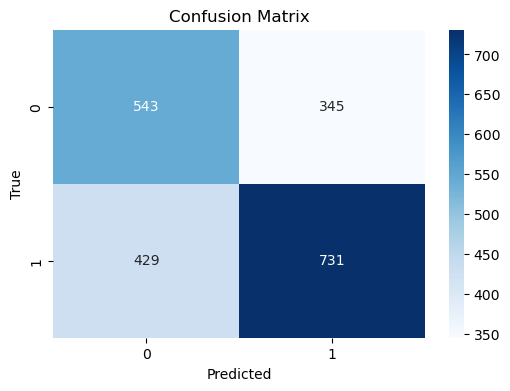

Cross-validation scores: [0.64670659 0.65704954 0.636908   0.636908   0.72440087]
Mean Cross-validation Accuracy: 0.6604


In [3]:
import pandas as pd
import zipfile
import re
import nltk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

# Unzip the file
with zipfile.ZipFile('liar_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('liar_dataset')

# Load the training data
train_df = pd.read_csv('liar_dataset/train.tsv', sep='\t', header=None)

# Assign meaningful column names
train_df.columns = ['id', 'label', 'statement', 'subject', 'speaker', 'speaker_job_title', 
                    'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 
                    'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context']

# Data Preprocessing
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Clean main text
train_df['clean_statement'] = train_df['statement'].apply(clean_text)

# Clean important metadata columns
train_df['subject_clean'] = train_df['subject'].apply(clean_text)
train_df['speaker_job_title_clean'] = train_df['speaker_job_title'].apply(clean_text)
train_df['party_affiliation_clean'] = train_df['party_affiliation'].apply(clean_text)

# Feature extraction
# TF-IDF for statement (main text)
vectorizer_statement = TfidfVectorizer(max_features=5000)
X_statement = vectorizer_statement.fit_transform(train_df['clean_statement'])

# TF-IDF for metadata: subject
vectorizer_subject = TfidfVectorizer(max_features=100)
X_subject = vectorizer_subject.fit_transform(train_df['subject_clean'])

# TF-IDF for metadata: speaker job title
vectorizer_job = TfidfVectorizer(max_features=100)
X_job = vectorizer_job.fit_transform(train_df['speaker_job_title_clean'])

# Label Encoding for metadata: party affiliation
label_encoder_party = LabelEncoder()
party_encoded = label_encoder_party.fit_transform(train_df['party_affiliation'].fillna('Unknown'))
party_encoded = party_encoded.reshape(-1, 1)  # reshape for hstack

# Combine all features together
X = hstack((X_statement, X_subject, X_job, party_encoded))

# Labels mapping
label_map = {
    'pants-fire': 0,
    'false': 0,
    'barely-true': 0,
    'half-true': 1,
    'mostly-true': 1,
    'true': 1
}
y = train_df['label'].map(label_map)

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'C': [0.1, 0.5, 1, 5, 10],
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_res, y_res)

# Best Logistic Regression Parameters
print(f"Best Logistic Regression Parameters: {grid_search.best_params_}")

# Train with the best parameters found by GridSearchCV
best_model = grid_search.best_estimator_

# Ensemble: Adding VotingClassifier with Logistic Regression, Random Forest, and SVM
logistic_regression = LogisticRegression(max_iter=1000, C=1, penalty='l2', solver='liblinear')
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
svm = SVC(kernel='linear', C=1, random_state=42)

voting_clf = VotingClassifier(estimators=[
    ('lr', logistic_regression),
    ('rf', random_forest),
    ('svc', svm)
], voting='hard')

# Train the ensemble model
voting_clf.fit(X_res, y_res)

# Evaluate the model
y_pred = voting_clf.predict(X_test)

# Model performance
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Cross-validation scores
cross_val = cross_val_score(voting_clf, X_res, y_res, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cross_val}")
print(f"Mean Cross-validation Accuracy: {cross_val.mean():.4f}")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kmani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\kmani\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression Performance:
Accuracy: 0.59716796875
              precision    recall  f1-score   support

           0       0.53      0.57      0.55       888
           1       0.65      0.62      0.63      1160

    accuracy                           0.60      2048
   macro avg       0.59      0.59      0.59      2048
weighted avg       0.60      0.60      0.60      2048



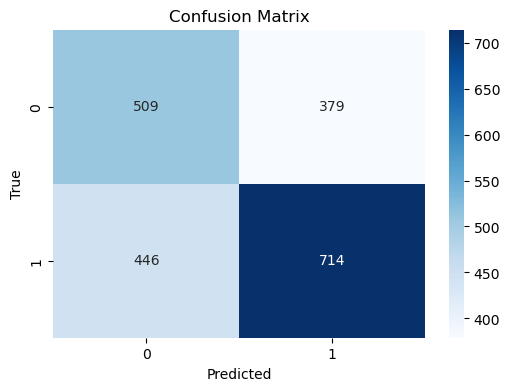

Random Forest Performance:
Accuracy: 0.6171875
              precision    recall  f1-score   support

           0       0.55      0.62      0.58       888
           1       0.68      0.62      0.65      1160

    accuracy                           0.62      2048
   macro avg       0.62      0.62      0.61      2048
weighted avg       0.62      0.62      0.62      2048



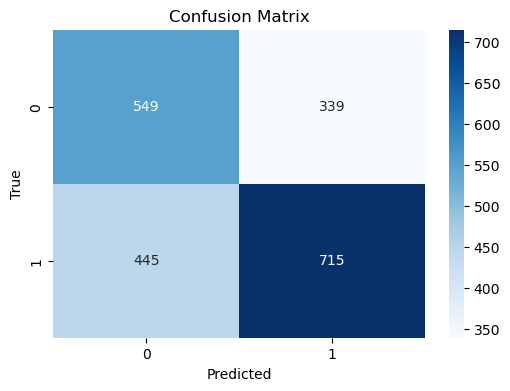

XGBoost Performance:
Accuracy: 0.6142578125
              precision    recall  f1-score   support

           0       0.55      0.56      0.56       888
           1       0.66      0.66      0.66      1160

    accuracy                           0.61      2048
   macro avg       0.61      0.61      0.61      2048
weighted avg       0.61      0.61      0.61      2048



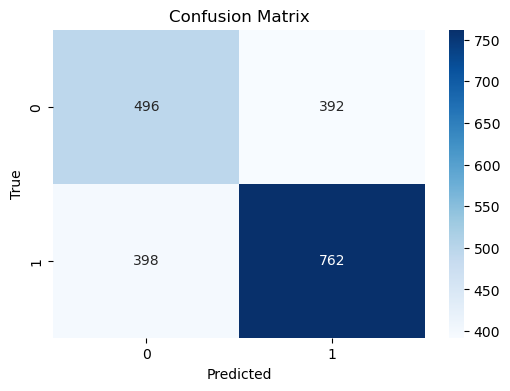

In [4]:
import pandas as pd
import zipfile
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imPipeline
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# Unzip the file
with zipfile.ZipFile('liar_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('liar_dataset')

# Load the training data
train_df = pd.read_csv('liar_dataset/train.tsv', sep='\t', header=None)

# Assign meaningful column names
train_df.columns = ['id', 'label', 'statement', 'subject', 'speaker', 'speaker_job_title', 
                    'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 
                    'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context']

# Clean the text and metadata columns
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

train_df['clean_statement'] = train_df['statement'].apply(clean_text)
train_df['subject_clean'] = train_df['subject'].apply(clean_text)
train_df['speaker_job_title_clean'] = train_df['speaker_job_title'].apply(clean_text)
train_df['party_affiliation_clean'] = train_df['party_affiliation'].apply(clean_text)

# Feature extraction
vectorizer_statement = TfidfVectorizer(max_features=5000)
X_statement = vectorizer_statement.fit_transform(train_df['clean_statement'])

# TF-IDF for metadata: subject, speaker_job_title, party_affiliation
vectorizer_subject = TfidfVectorizer(max_features=100)
X_subject = vectorizer_subject.fit_transform(train_df['subject_clean'])

vectorizer_job = TfidfVectorizer(max_features=100)
X_job = vectorizer_job.fit_transform(train_df['speaker_job_title_clean'])

label_encoder_party = LabelEncoder()
party_encoded = label_encoder_party.fit_transform(train_df['party_affiliation_clean'].fillna('Unknown')).reshape(-1, 1)

# Combine all features together
from scipy.sparse import hstack
X = hstack((X_statement, X_subject, X_job, party_encoded))

# Map the labels
label_map = {
    'pants-fire': 0,
    'false': 0,
    'barely-true': 0,
    'half-true': 1,
    'mostly-true': 1,
    'true': 1
}
y = train_df['label'].map(label_map)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Experiment with different models

# Logistic Regression
log_reg = LogisticRegression(C=5, penalty='l2', solver='saga', max_iter=1000)
log_reg.fit(X_train_resampled, y_train_resampled)
log_reg_pred = log_reg.predict(X_test)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)
rf_pred = rf_model.predict(X_test)

# XGBoost
xgb_model = XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)
xgb_pred = xgb_model.predict(X_test)

# Evaluate the models
def evaluate_model(y_test, y_pred):
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Logistic Regression evaluation
print("Logistic Regression Performance:")
evaluate_model(y_test, log_reg_pred)

# Random Forest evaluation
print("Random Forest Performance:")
evaluate_model(y_test, rf_pred)

# XGBoost evaluation
print("XGBoost Performance:")
evaluate_model(y_test, xgb_pred)
